# Data

### Load dataset

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Paths to dataset (Update if needed)
train_dir = "/content/drive/MyDrive/Traffic/Data/Classify/Train_jpec"
test_dir = "/content/drive/MyDrive/Traffic/Data/Classify/Val_jpec"

# Define batch size & image size
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

# Load dataset (One-hot encoding for classification)
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 38774 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.


### Data process

In [5]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Apply EfficientNet preprocessing
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),  # ±10% rotation
    tf.keras.layers.RandomZoom(0.2),  # Zoom in/out
    tf.keras.layers.RandomBrightness(0.2),  # Adjust brightness
    tf.keras.layers.RandomContrast(0.2)  # Adjust contrast
])

# Apply Data Augmentation & Preprocessing Together
def preprocess_and_augment(image, label):
    image = data_augmentation(image)  # Augment first
    image = preprocess_input(image)  # Normalize for EfficientNet
    return image, label

train_ds = train_ds.map(preprocess_and_augment)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))  # No augmentation for test set

for images, labels in train_ds.take(1):
    print(f"Batch shape: {images.shape}, Label shape: {labels.shape}")


Batch shape: (128, 224, 224, 3), Label shape: (128, 43)


# Model

### Build

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model (for initial training phase)
base_model.trainable = False

# Add custom layers on top of EfficientNet
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to vector
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(256, activation="relu")(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Dropout again
output_layer = Dense(43, activation="softmax")(x)  # 43-class output

# Define the full model
model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 224, 224, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,388,558 (16.74 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2
)

# Define ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    "best_model.h5",  # File name
    monitor="val_loss",  # Save model with lowest validation loss
    save_best_only=True,  # Save only the best model
    mode="min",  # Minimize val_loss
    verbose=1
)

# Use all callbacks in a single list
callbacks = [early_stopping, reduce_lr, checkpoint]

# Train the model with the correct callbacks
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4158 - loss: 2.0603
Epoch 1: val_loss improved from inf to 0.90092, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 2043s 7s/step - accuracy: 0.4162 - loss: 2.0586 - val_accuracy: 0.7148 - val_loss: 0.9009 - learning_rate: 0.0010
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6679 - loss: 1.0288
Epoch 2: val_loss improved from 0.90092 to 0.74313, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.6680 - loss: 1.0286 - val_accuracy: 0.7652 - val_loss: 0.7431 - learning_rate: 0.0010
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7157 - loss: 0.8727
Epoch 3: val_loss improved from 0.74313 to 0.67495, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.7157 - loss: 0.8726 - val_accuracy: 0.7859 - val_loss: 0.6750 - learning_rate: 0.0010
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7426 - loss: 0.7914
Epoch 4: val_loss improved from 0.67495 to 0.66829, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.7426 - loss: 0.7913 - val_accuracy: 0.7822 - val_loss: 0.6683 - learning_rate: 0.0010
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7574 - loss: 0.7444
Epoch 5: val_loss improved from 0.66829 to 0.64915, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.7574 - loss: 0.7443 - val_accuracy: 0.7817 - val_loss: 0.6491 - learning_rate: 0.0010
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7683 - loss: 0.7015
Epoch 6: val_loss improved from 0.64915 to 0.62257, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.7683 - loss: 0.7014 - val_accuracy: 0.7918 - val_loss: 0.6226 - learning_rate: 0.0010
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7735 - loss: 0.6790
Epoch 7: val_loss did not improve from 0.62257
303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.7735 - loss: 0.6790 - val_accuracy: 0.7875 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7797 - loss: 0.6605
Epoch 8: val_loss did not improve from 0.62257
303/303 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.7797 - loss: 0.6604 - val_accuracy: 0.7945 - val_loss: 0.6271 - learning_rate: 0.0010
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7947 - loss: 0.6221
Epoch 9: val_loss improved from 0.62257 to 0.61448, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.7947 - loss: 0.6221 - val_accuracy: 0.7975 - val_loss: 0.6145 - learning_rate: 5.0000e-04
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8011 - loss: 0.6053
Epoch 10: val_loss improved from 0.61448 to 0.60784, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.8011 - loss: 0.6053 - val_accuracy: 0.8021 - val_loss: 0.6078 - learning_rate: 5.0000e-04
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8056 - loss: 0.5881
Epoch 11: val_loss improved from 0.60784 to 0.59838, saving model to best_model.h5


303/303 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.8056 - loss: 0.5881 - val_accuracy: 0.8055 - val_loss: 0.5984 - learning_rate: 5.0000e-04
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8103 - loss: 0.5795
Epoch 12: val_loss did not improve from 0.59838
303/303 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.8103 - loss: 0.5794 - val_accuracy: 0.7979 - val_loss: 0.6161 - learning_rate: 5.0000e-04
Epoch 13/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8097 - loss: 0.5673
Epoch 13: val_loss did not improve from 0.59838
303/303 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.8098 - loss: 0.5673 - val_accuracy: 0.7998 - val_loss: 0.6089 - learning_rate: 5.0000e-04
Epoch 14/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8164 - loss: 0.5532
Epoch 14: val_loss did not improve from 0.59838
303/303 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.8164 - loss: 0.5532 - val_accuracy: 0.8010 - val_loss: 0.6072 - learning_rate: 2.5000e-04


### Evaluation

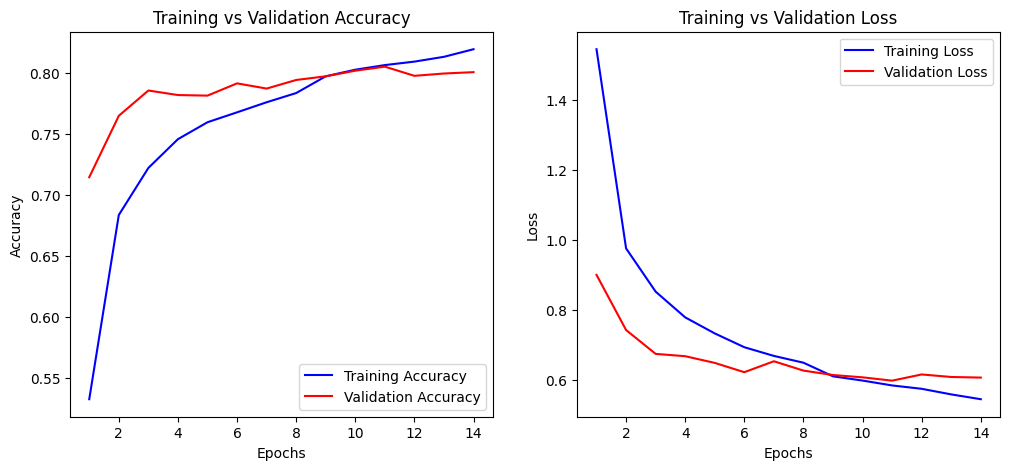

303/303 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9091 - loss: 0.3188
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.8059 - loss: 0.5956
Train Accuracy: 0.9102, Train Loss: 0.3160
Test Accuracy: 0.8055, Test Loss: 0.5984


In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function
plot_training_curves(history)

final_train_loss, final_train_acc = model.evaluate(train_ds)
final_test_loss, final_test_acc = model.evaluate(test_ds)

print(f"Train Accuracy: {final_train_acc:.4f}, Train Loss: {final_train_loss:.4f}")
print(f"Test Accuracy: {final_test_acc:.4f}, Test Loss: {final_test_loss:.4f}")

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load your trained EfficientNet model
model_path = "/content/best_model.h5"  # Update with correct path
model = tf.keras.models.load_model(model_path)

# Get predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:  # Iterate over test batches
    predictions = model.predict(images)  # Predict classes
    predicted_classes = np.argmax(predictions, axis=1)  # Get highest probability class
    true_classes = np.argmax(labels.numpy(), axis=1)  # Convert one-hot labels to class indices

    y_pred.extend(predicted_classes)
    y_true.extend(true_classes)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ===============================
# 1️⃣ Compute Performance Metrics
# ===============================
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"\n✅ EfficientNet-B0 Performance Report:")
print(f"🔹 Accuracy:  {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall:    {recall:.4f}")
print(f"🔹 F1 Score:  {f1:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━

# Fine-tune

In [2]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/drive/MyDrive/Traffic/Classification/model/best_model.h5")

# Check the current trainable status of layers
for layer in model.layers:
    print(layer.name, layer.trainable)  # This will show which layers are frozen


input_layer_6 True
rescaling_6 False
normalization_3 False
rescaling_7 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
blo

In [6]:
# Unfreeze the last 20 layers of EfficientNetB0
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


### Calculate the class weight for class imbalance problem

In [7]:
import os
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Path to training dataset
train_dir = "/content/drive/MyDrive/Traffic/Data/Classify/Train_jpec"

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}

# Convert to list for class_weight calculation
class_labels = list(class_counts.keys())
num_samples = list(class_counts.values())

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.arange(len(class_labels)),  # Class indices
                                     y=np.repeat(np.arange(len(class_labels)), num_samples))

# Convert to dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed class weights:", class_weight_dict)

Computed class weights: {0: 4.2939091915836105, 1: 0.5051657872451306, 2: 0.4486173782251533, 3: 0.6831219168428471, 4: 0.42939091915836103, 5: 0.41746339362618434, 6: 1.156052474657126, 7: 1.4313030638612034, 8: 2.1469545957918053, 9: 0.81236119840771, 10: 0.7514341085271318, 11: 4.2939091915836105, 12: 0.40076485788113697, 13: 2.504780361757106, 14: 2.7324876673713883, 15: 2.312104949314252, 16: 1.768080255357957, 17: 3.3397071490094747, 18: 0.6011472868217054, 19: 1.5028682170542635, 20: 3.757170542635659, 21: 1.6698535745047374, 22: 3.3397071490094747, 23: 0.6395183902358569, 24: 2.0038242894056846, 25: 1.156052474657126, 26: 3.757170542635659, 27: 1.3087386505552367, 28: 2.1469545957918053, 29: 0.7514341085271318, 30: 2.312104949314252, 31: 4.2939091915836105, 32: 0.4356139759577576, 33: 3.005736434108527, 34: 0.4554146112285647, 35: 2.504780361757106, 36: 3.757170542635659, 37: 3.757170542635659, 38: 0.48479619904976246, 39: 2.1469545957918053, 40: 0.6261950904392765, 41: 0.63951

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

save_dir ="/content/drive/MyDrive/Traffic/Classification/model"

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,  # Stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True
)

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce LR by half if val_loss doesn't improve
    patience=2
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, "fine_tuned_model.keras"),  # Save as .keras format
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Define the list of callbacks
callbacks = [early_stopping, reduce_lr, checkpoint]

EPOCHS_FINE_TUNE = 10  # Adjust as needed

history_fine = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS_FINE_TUNE,
    class_weight=class_weight_dict,  # Apply class balancing
    callbacks=callbacks  # Early stopping, LR scheduler, model checkpoint
)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8294 - loss: 0.4441
Epoch 1: val_loss improved from inf to 0.54990, saving model to /content/drive/MyDrive/Traffic/Classification/model/fine_tuned_model.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.8294 - loss: 0.4441 - val_accuracy: 0.8177 - val_loss: 0.5499 - learning_rate: 1.0000e-05
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8314 - loss: 0.4350
Epoch 2: val_loss improved from 0.54990 to 0.54760, saving model to /content/drive/MyDrive/Traffic/Classification/model/fine_tuned_model.keras
303/303 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.8314 - loss: 0.4350 - val_accuracy: 0.8188 - val_loss: 0.5476 - learning_rate: 1.0000e-05
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8334 - loss: 0.4244
Epoch 3: val_loss improved from 0.54760 to 0.54075, saving model to /content/drive/MyDrive/Traffic/Classification/model/fine_tuned_model.keras
303/303 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

### Evaluation

In [17]:
from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = [], []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Print classification report
print(classification_report(y_true, y_pred, digits=4))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━

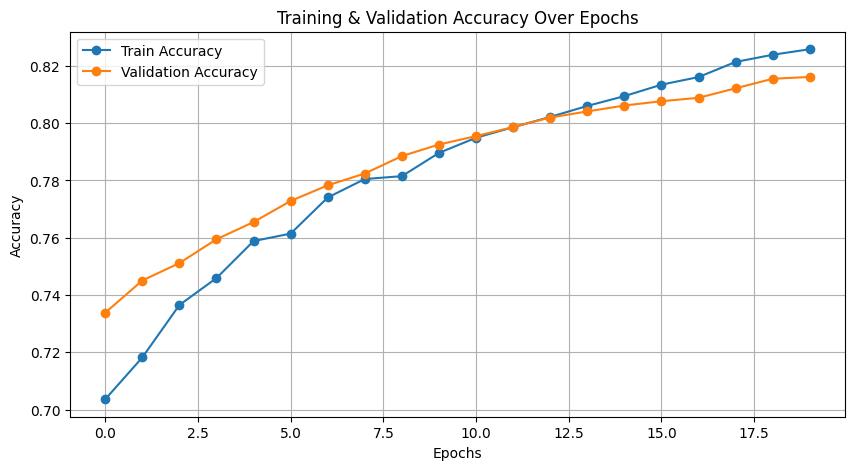

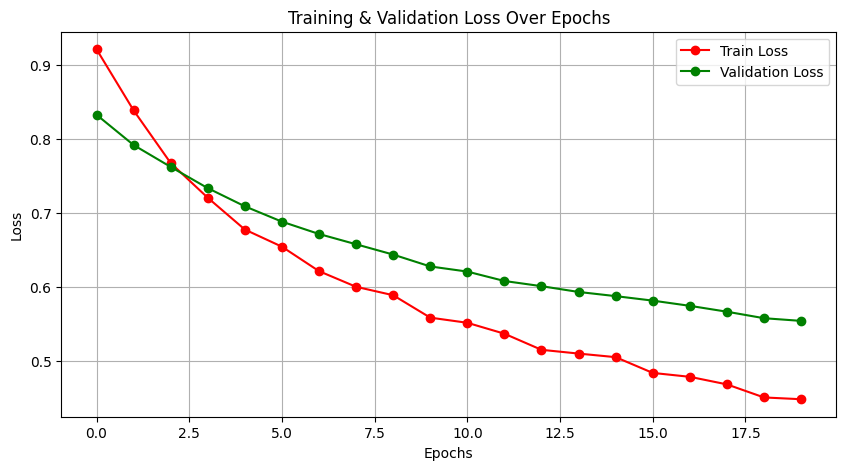

In [18]:
import matplotlib.pyplot as plt

# Extract training history
history = history_fine.history  # Ensure 'history_fine' is the variable from model.fit()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history["accuracy"], label="Train Accuracy", marker="o")
plt.plot(history["val_accuracy"], label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history["loss"], label="Train Loss", marker="o", color="red")
plt.plot(history["val_loss"], label="Validation Loss", marker="o", color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
